<a href="https://colab.research.google.com/github/KingOfRlyeh/BlackJackStochasticStrategies/blob/main/jackblack_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global state
running_count = 0
true_count = 0
current_bet = 5
shoe = []
last_result = 'loss'

# Setup

def new_shoe(decks=6):
    single_deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
    return single_deck * decks

def hilo_count(num):
    if 2 <= num <= 6:
        return 1
    elif 7 <= num <= 9:
        return 0
    elif num in [10, 1]:
        return -1
    return 0

def draw_card():
    global shoe, running_count, true_count
    if len(shoe) < 15:
        shoe = new_shoe()
        random.shuffle(shoe)
        running_count = 0
    card = shoe.pop()
    running_count += hilo_count(card)
    true_count = running_count / (len(shoe) / 52)
    return card

def hand_value(hand):
    total = sum(hand)
    aces = hand.count(1)
    while aces > 0 and total + 10 <= 21:
        total += 10
        aces -= 1
    return total

def is_blackjack(hand):
    return len(hand) == 2 and sorted(hand) == [1, 10]

# Strategy

def basic_strategy(hand, dealer_upcard):
    return 'H' if hand_value(hand) < 17 else 'S'


def matrix_strategy_boilerplate(player_hand, dealer_upcard):
    dealer = 11 if dealer_upcard == 1 else dealer_upcard
    def is_soft(hand):
        return 1 in hand and sum(hand) + 10 <= 21

    value = sum(player_hand)
    if len(player_hand) == 2 and player_hand[0] == player_hand[1]:
        pair = player_hand[0]
        if pair in [1, 8]: return 'P'
        if pair in [2, 3]: return 'P' if dealer in range(2,8) else 'H'
        if pair == 4: return 'P' if dealer in [5,6] else 'H'
        if pair == 6: return 'P' if dealer in range(2,7) else 'H'
        if pair == 7: return 'P' if dealer in range(2,8) else 'H'
        if pair == 9: return 'P' if dealer in [2,3,4,5,6,8,9] else 'S'
        if pair == 5: return 'D' if dealer <= 9 else 'H'
        if pair == 10: return 'S'

    if is_soft(player_hand):
        soft_total = value + 10
        if soft_total >= 19: return 'S'
        if soft_total == 18:
            if dealer in [2,7,8]: return 'S'
            if dealer in range(3,7): return 'Ds'
            return 'H'
        if soft_total == 17: return 'D' if dealer in range(3,7) else 'H'
        if soft_total == 16 or soft_total == 15: return 'D' if dealer in [4,5,6] else 'H'
        if soft_total == 14 or soft_total == 13: return 'D' if dealer in [5,6] else 'H'
        return 'H'
    else:
        if value >= 17: return 'S'
        if value == 16: return 'S' if dealer in range(2,7) else 'H'
        if value == 15: return 'S' if dealer in range(2,7) else 'H'
        if value == 14: return 'S' if dealer in range(2,7) else 'H'
        if value == 13: return 'S' if dealer in range(2,7) else 'H'
        if value == 12: return 'S' if dealer in [4,5,6] else 'H'
        if value == 11: return 'D'
        if value == 10: return 'D' if dealer <= 9 else 'H'
        if value == 9: return 'D' if dealer in range(3,7) else 'H'
        return 'H'

def matrix_strategy(hand, dealer_upcard):
    action = matrix_strategy_boilerplate(hand, dealer_upcard)
    return action

# Betting

def dummy_bet_strategy():
    global current_bet, last_result
    if last_result == 'win':
        current_bet *= 2
    elif last_result == 'loss':
        current_bet = max(5, current_bet / 2)
    return int(current_bet)


def hilo_strategy():
    global current_bet, true_count
    base_bet = 5
    max_bet = 200

    if true_count <= 1:
        current_bet = base_bet
    else:
        current_bet = base_bet * int(true_count - 1)
        current_bet = min(current_bet, max_bet)

    return current_bet

# Simulation

def simulate_round(player_strategy, bet_strategy):
    global last_result

    dealer_hand = [draw_card(), draw_card()]
    dealer_upcard = dealer_hand[0]
    hands = [{'cards': [draw_card(), draw_card()], 'bet': bet_strategy(), 'doubled': False}]
    results = []

    for hand in hands:
        while True:
            action = player_strategy(hand['cards'], dealer_upcard)
            if action == 'H':
                hand['cards'].append(draw_card())
                if hand_value(hand['cards']) > 21:
                    break
            elif action == 'S':
                break
            elif action == 'D' and len(hand['cards']) == 2:
                hand['cards'].append(draw_card())
                hand['bet'] *= 2
                hand['doubled'] = True
                break
            elif action == 'Ds' and len(hand['cards']) == 2:
                hand['cards'].append(draw_card())
                hand['bet'] *= 2
                hand['doubled'] = True
                break
            elif action == 'P' and len(hand['cards']) == 2:
                c = hand['cards'][0]
                hands.remove(hand)
                hands.append({'cards': [c, draw_card()], 'bet': hand['bet'], 'doubled': False})
                hands.append({'cards': [c, draw_card()], 'bet': hand['bet'], 'doubled': False})
                break
            else:
                break

    while hand_value(dealer_hand) < 17:
        dealer_hand.append(draw_card())

    dealer_val = hand_value(dealer_hand)
    for hand in hands:
        player_val = hand_value(hand['cards'])
        if player_val > 21:
            result = 'loss'
        elif is_blackjack(hand['cards']) and not is_blackjack(dealer_hand):
            result = 'blackjack'
        elif dealer_val > 21 or player_val > dealer_val:
            result = 'win'
        elif player_val < dealer_val:
            result = 'loss'
        else:
            result = 'push'
        results.append({
            'player_hand': hand['cards'],
            'dealer_hand': dealer_hand,
            'player_value': player_val,
            'dealer_value': dealer_val,
            'result': result,
            'bet': hand['bet'],
            'doubled': hand['doubled']
        })
        if result != 'push':
            last_result = result

    return results

# Evaluation

def compute_payout(row):
    if row['result'] == 'blackjack':
        return int(1.5 * row['bet'])
    elif row['result'] == 'win':
        return row['bet']
    elif row['result'] == 'loss':
        return -row['bet']
    else:
        return 0

# Run
records = []
for _ in range(100_000):
    hands = simulate_round(matrix_strategy, hilo_strategy)
    records.extend(hands)

df = pd.DataFrame(records)
df['payout'] = df.apply(compute_payout, axis=1)
df['standing'] = df['payout'].cumsum()


In [10]:
import numpy as np
import matplotlib.pyplot as plt


def many_trials_statistics(n_trials, n_rounds, play_strategy, bet_strategy):
    trajectories = []

    for _ in range(n_trials):
        # Reset global state
        running_count = 0
        true_count = 0
        current_bet = 5
        shoe = []
        last_result = 'loss'

        records = []
        # Simulate up to n_rounds, but collect all hands played within those rounds
        round_count = 0
        while round_count < n_rounds:
            hands = simulate_round(play_strategy, bet_strategy)
            records.extend(hands)
            # Assuming simulate_round always plays at least one hand, increment round_count
            round_count += len(hands) # This is not strictly correct as one round can have multiple hands if splitting occurs

        # Re-simulate to ensure exactly n_rounds are played per trial
        records = []
        for _ in range(n_rounds):
            hands = simulate_round(matrix_strategy, hilo_strategy)
            records.extend(hands)


        df = pd.DataFrame(records)
        df['payout'] = df.apply(compute_payout, axis=1)
        df['standing'] = df['payout'].cumsum()

        # Ensure each trajectory has exactly n_rounds data points by resampling or padding
        # A simpler approach is to take the cumulative sum after each round
        # Let's adjust the simulation loop to record standing after each round

        standing_per_round = []
        cumulative = 0
        # Reset global state again before the actual simulation for trajectory
        running_count = 0
        true_count = 0
        current_bet = 5
        shoe = []
        last_result = 'loss'

        for _ in range(n_rounds):
            hands = simulate_round(matrix_strategy, hilo_strategy)
            round_payout = sum(compute_payout(pd.Series(hand)) for hand in hands) # Sum payouts for all hands in the round
            cumulative += round_payout
            standing_per_round.append(cumulative)

        trajectory = np.array(standing_per_round)

        trajectories.append(trajectory)

    # Convert to numpy and compute statistics
    trajectories = np.array(trajectories)
    median = np.median(trajectories, axis=0)
    q10 = np.percentile(trajectories, 10, axis=0)
    q90 = np.percentile(trajectories, 90, axis=0)

    # Plot cone
    plt.figure(figsize=(10,6))
    plt.plot(median, label='Median Standing', color='black')
    plt.fill_between(range(n_rounds), q10, q90, color='gray', alpha=0.5, label='10th–90th Percentile Range')
    plt.title('Monte Carlo Cone of Possibility (Standing over Time)')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Standing')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

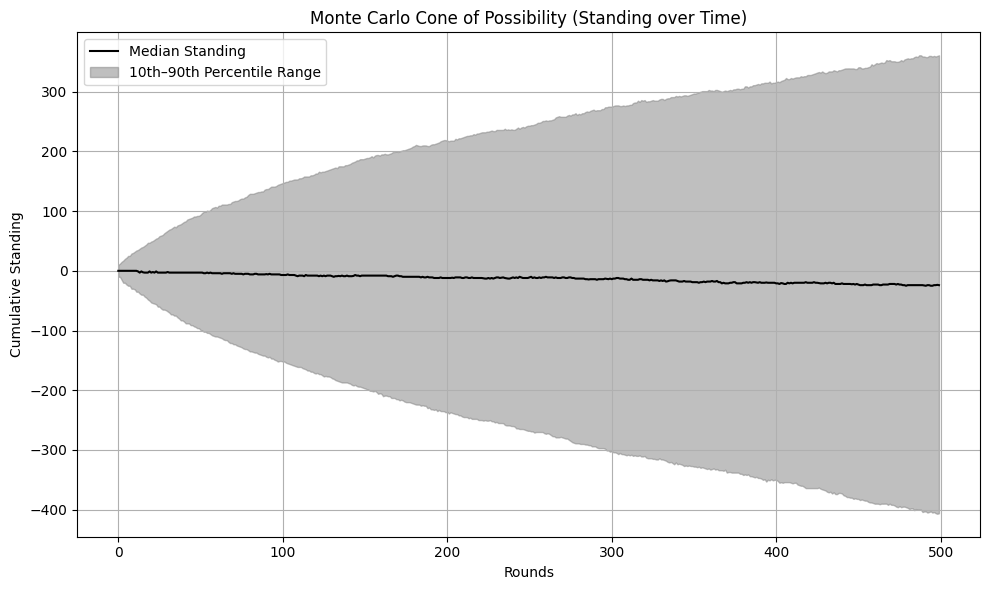

In [ ]:
many_trials_statistics(10000, 500)

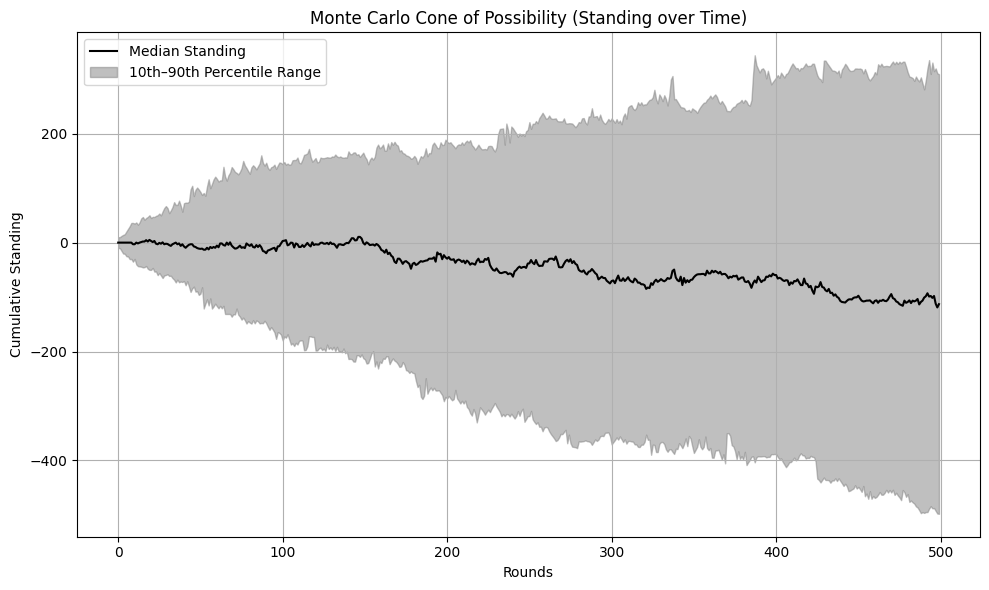

In [11]:
many_trials_statistics(100, 500, basic_strategy, dummy_bet_strategy)

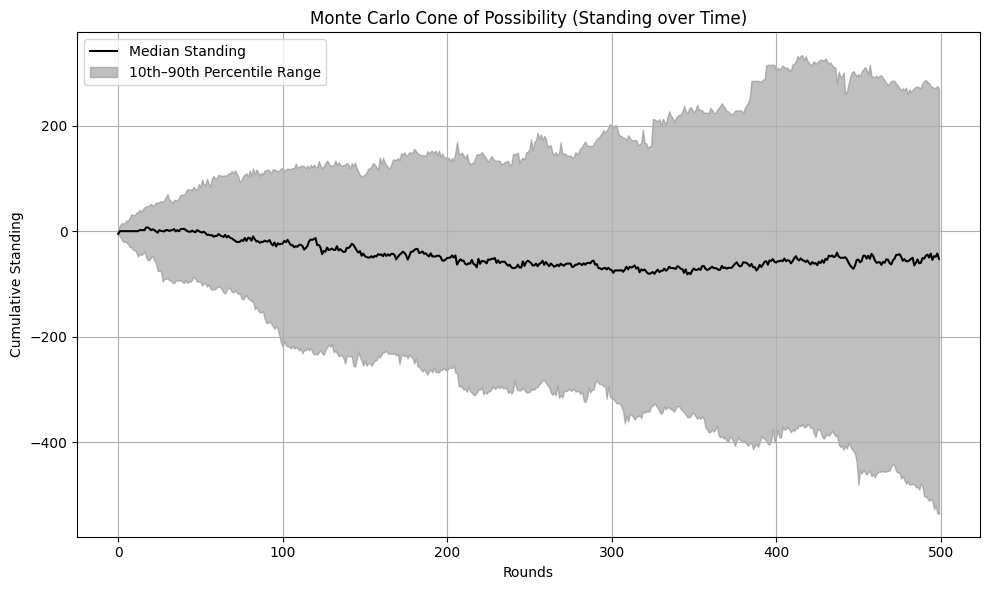

In [12]:
many_trials_statistics(100, 500, matrix_strategy, dummy_bet_strategy)

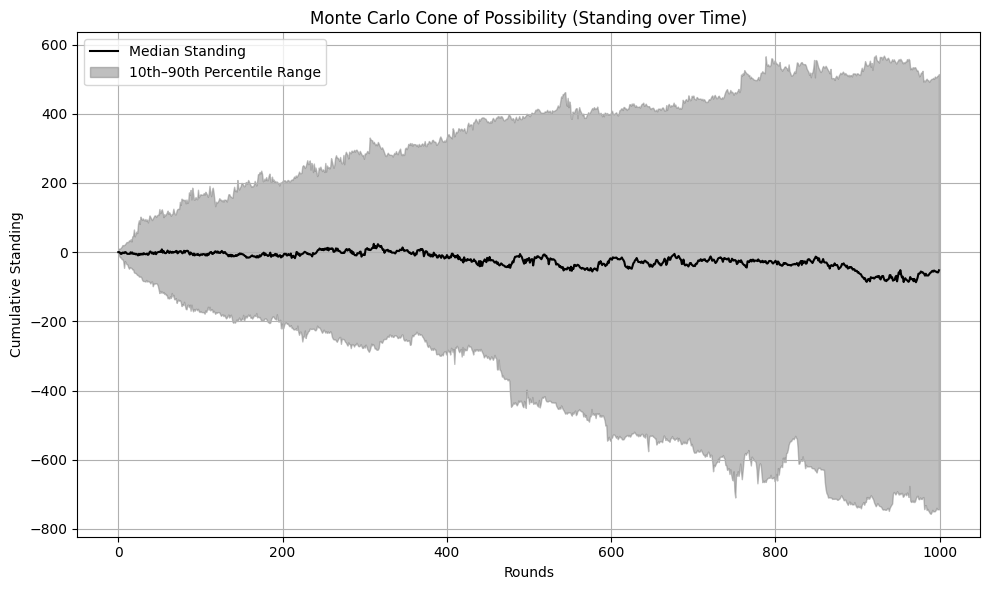

In [18]:
many_trials_statistics(100, 1000, basic_strategy, hilo_strategy)

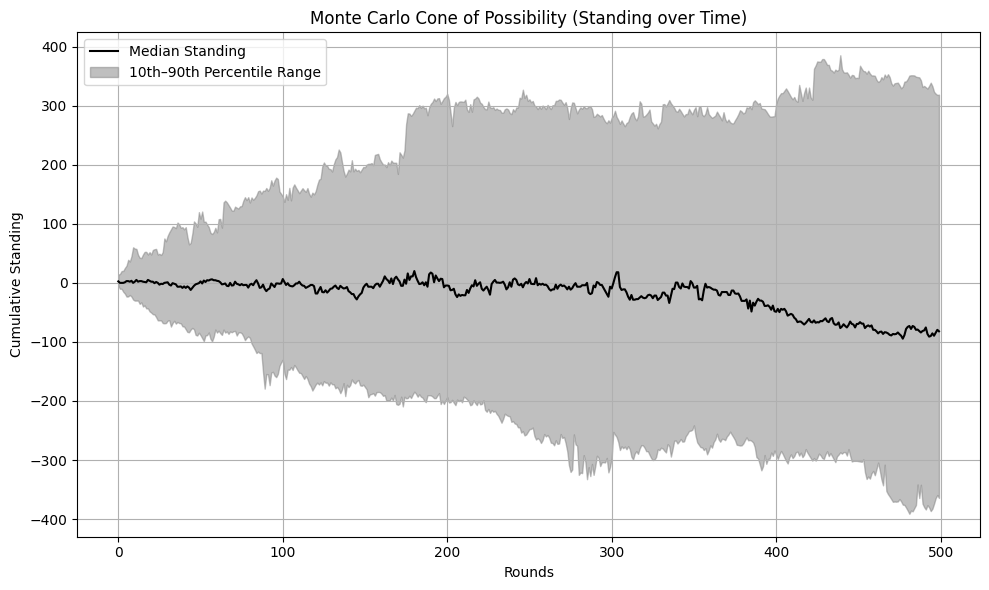

In [17]:
many_trials_statistics(100, 500, matrix_strategy, hilo_strategy)

Conclusion: don't gamble, kids